# Experiment Tracking and Model Registry Lab

## Overview

In this lab you will each download a new dataset and attempt to train a good model, and use mlflow to keep track of all of your experiments, log your metrics, artifacts and models, and then register a final set of models for "deployment", though we won't actually deploy them anywhere yet.

## Goal

Your goal is **not** to become a master at MLFlow - this is not a course on learning all of the ins and outs of MLFlow. Instead, your goal is to understand when and why it is important to track your model development process (tracking experiments, artifacts and models) and to get into the habit of doing so, and then learn at least the basics of how MLFlow helps you do this so that you can then compare with other tools that are available.

## Data

You can choose your own dataset to use here. It will be helpful to choose a dataset that is already fairly clean and easy to work with. You can even use a dataset that you've used in a previous course. We will do a lot of labs where we do different things with datasets, so if you can find one that is interesting enough for modeling, it should work for most of the rest of the course. 

There are tons of places where you can find open public datasets. Choose something that interests you, but don't overthink it.

[Kaggle Datasets](https://www.kaggle.com/datasets)  
[HuggingFace Datasets](https://huggingface.co/docs/datasets/index)  
[Dagshub Datasets](https://dagshub.com/datasets/)  
[UCI](https://archive.ics.uci.edu/ml/datasets.php)  
[Open Data on AWS](https://registry.opendata.aws/)  
[Yelp](https://www.yelp.com/dataset)  
[MovieLens](https://grouplens.org/datasets/movielens/)  
And so many more...

## Instructions

Once you have selected a set of data, create a brand new experiment in MLFlow and begin exploring your data. Do some EDA, clean up, and learn about your data. You do not need to begin tracking anything yet, but you can if you want to (e.g. you can log different versions of your data as you clean it up and do any feature engineering). Do not spend a ton of time on this part. Your goal isn't really to build a great model, so don't spend hours on feature engineering and missing data imputation and things like that.

Once your data is clean, begin training models and tracking your experiments. If you intend to use this same dataset for your final project, then start thinking about what your model might look like when you actually deploy it. For example, when you engineer new features, be sure to save the code that does this, as you will need this in the future. If your final model has 1000 complex features, you might have a difficult time deploying it later on. If your final model takes 15 minutes to train, or takes a long time to score a new batch of data, you may want to think about training a less complex model.

Now, when tracking your experiments, at a *minimum*, you should:

1. Try at least 3 different ML algorithms (e.g. linear regression, decision tree, random forest, etc.).
2. Do hyperparameter tuning for **each** algorithm.
3. Do some very basic feature selection, and repeat the above steps with these reduced sets of features.
4. Identify the top 3 best models and note these down for later.
6. Choose the **final** "best" model that you would deploy or use on future data, stage it (in MLFlow), and run it on the test set to get a final measure of performance. Don't forget to log the test set metric.
7. Be sure you logged the exact training, validation, and testing datasets for the 3 best models, as well as hyperparameter values, and the values of your metrics.  
8. Push your code to Github. No need to track the mlruns folder, the images folder, any datasets, or the sqlite database in git.

### Turning It In

In the MLFlow UI, next to the refresh button you should see three vertical dots. Click the dots and then download your experiments as a csv file. Open the csv file in Excel and highlight the rows for your top 3 models from step 4, highlight the run where you applied your best model to the test set, and then save as an excel file. Take a snapshot of the Models page in the MLFLow UI showing the model you staged in step 6 above. Submit the excel file and the snapshot to Canvas.

___

### Load Stuff

Dataset: [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

In [1]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [2]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 
  
data = pd.concat([X, y], axis=1)

X = X.values
y = y.values.ravel()

print('Shape:', data.shape)
data.head()

Shape: (569, 31)


,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


### EDA

In [3]:
def get_df_info(df):
    """ 
    Function to see information in `df`. Contains all information
    in `df.info()` but more. Use this function to save space. 

    Parameters
    ----------
    df (pd.DataFrame): DataFrame for which you want information. 

    Returns
    -------
    df_info (pd.DataFrame): DataFrame with information about `df`. 

    """
    df_info = pd.DataFrame({
        'Column': df.columns,
        'Non-Null Count': df.notnull().sum().values,
        'Dtype': df.dtypes.values,
        'Unique Value Count': df.nunique().values,
        'Missing Count': df.isna().sum().values
    })
    return df_info

get_df_info(data)

,Column,Non-Null Count,Dtype,Unique Value Count,Missing Count
0,radius1,569,float64,456,0
1,texture1,569,float64,479,0
2,perimeter1,569,float64,522,0
3,area1,569,float64,539,0
4,smoothness1,569,float64,474,0
5,compactness1,569,float64,537,0
6,concavity1,569,float64,537,0
7,concave_points1,569,float64,542,0
8,symmetry1,569,float64,432,0
9,fractal_dimension1,569,float64,499,0


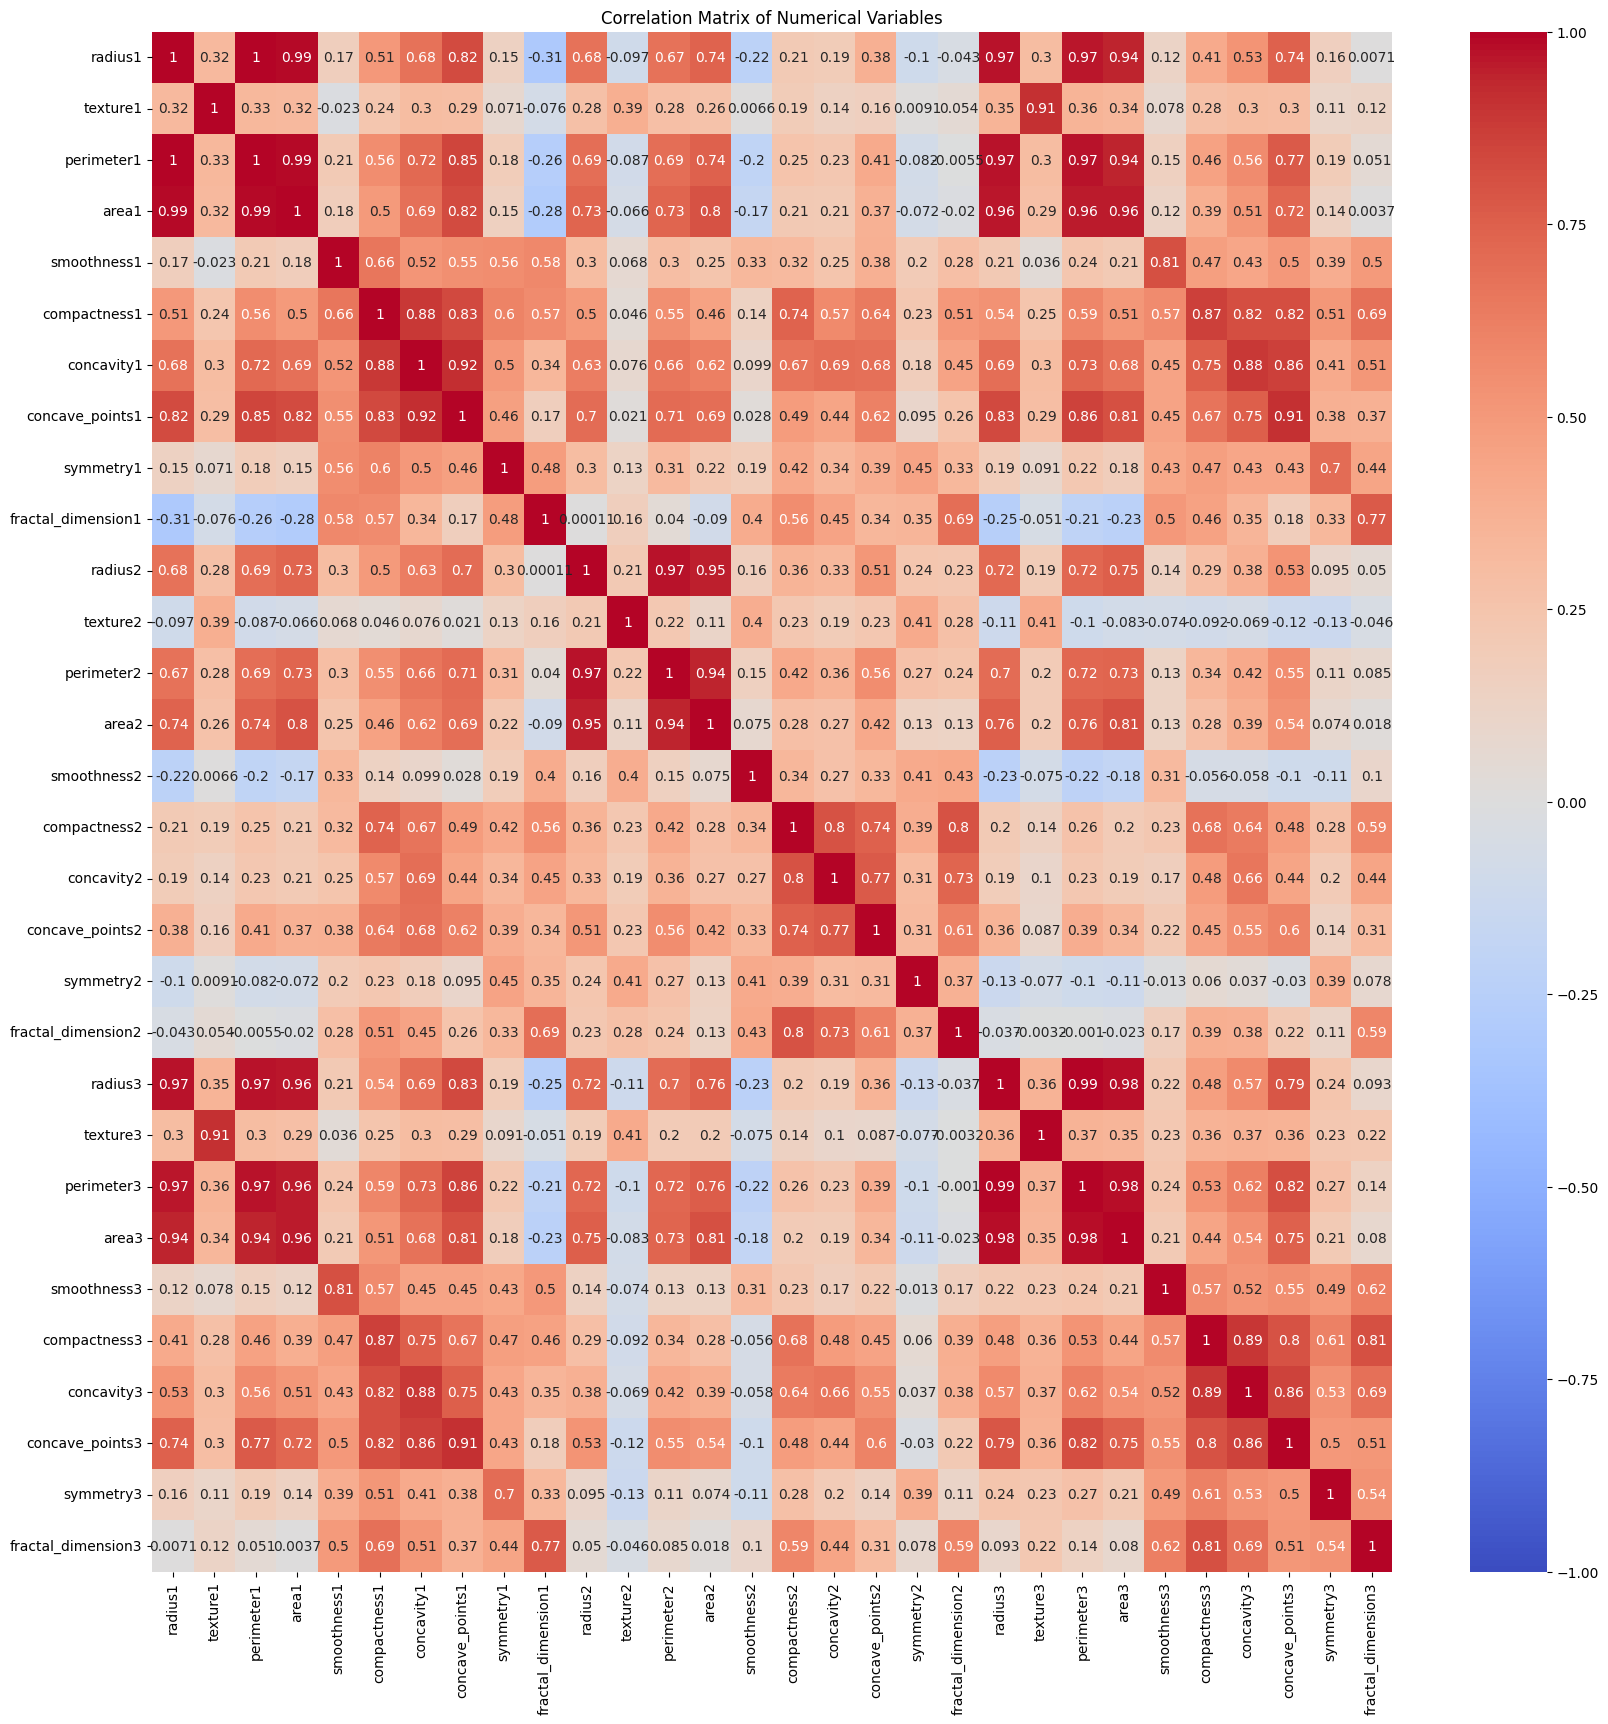

In [4]:
numeric_features = data.select_dtypes(include=np.number).columns.tolist()
correlation_matrix = data[numeric_features].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

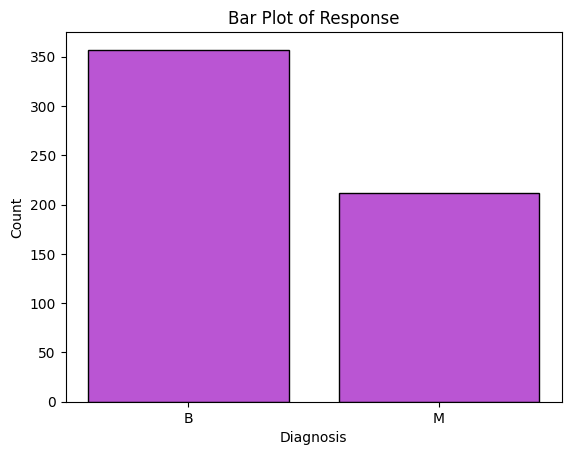

In [5]:
counts = data["Diagnosis"].value_counts()
plt.bar(counts.index, counts.values, edgecolor='black', color='mediumorchid')
plt.title("Bar Plot of Response")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

### Steps 1 and 2

In [6]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

mlflow.set_tracking_uri("sqlite:///mlflow.db")

def run_experiment(X_train, y_train, 
                   X_val=None, y_val=None, 
                   X_test=None, y_test=None,
                   data_version="full", 
                   experiment_name='lab2'):
    
    mlflow.set_experiment(experiment_name)

    def objective(params):
        with mlflow.start_run():
            model_type = params['type']
            del params['type']

            if model_type == 'dt':
                clf = DecisionTreeClassifier(**params)
            elif model_type == 'rf':
                clf = RandomForestClassifier(**params)
            elif model_type == 'adaboost':
                clf = AdaBoostClassifier(**params)
            else:
                return {'loss': float('inf'), 'status': STATUS_OK}

            # Fit and evaluate
            clf.fit(X_train, y_train)
            train_acc = accuracy_score(y_train, clf.predict(X_train))
            mlflow.log_metric('train_accuracy', train_acc)

            if X_val is not None and y_val is not None:
                val_acc = accuracy_score(y_val, clf.predict(X_val))
                mlflow.log_metric("val_accuracy", val_acc)

            if X_test is not None and y_test is not None:
                test_acc = accuracy_score(y_test, clf.predict(X_test))
                mlflow.log_metric("test_accuracy", test_acc)

            # Log metadata
            mlflow.set_tag("Model", f"{model_type}_classifier")
            mlflow.set_tag("data_version", data_version)

            mlflow.log_params(params)
            mlflow.log_param("n_features", X_train.shape[1])

            input_example = pd.DataFrame([X_train[0]], columns=[f'feature_{i}' for i in range(X_train.shape[1])])
            signature = infer_signature(X_train, clf.predict(X_train))
            mlflow.sklearn.log_model(
                clf,
                artifact_path='better_models',
                input_example=input_example,
                signature=signature
            )

            mlflow.end_run()
            if 'test_acc' in locals():
                score_to_optimize = test_acc
            elif 'val_acc' in locals():
                score_to_optimize = val_acc
            else:
                score_to_optimize = train_acc

            return {'loss': -score_to_optimize, 'status': STATUS_OK}

    search_space = hp.choice('model_type', [
        {
            'type': 'dt',
            'criterion': hp.choice('dt_criterion', ['gini', 'entropy']),
            'max_depth': hp.choice('dt_max_depth', [None, hp.randint('dt_max_depth_int', 1, 10)]),
            'min_samples_split': hp.randint('dt_min_samples_split', 2, 10)
        },
        {
            'type': 'rf',
            'n_estimators': hp.randint('rf_n_estimators', 50, 300),
            'max_features': hp.choice('rf_max_features', [0.5, 0.8]),
            'criterion': hp.choice('rf_criterion', ['gini', 'entropy'])
        },
        {
            'type': 'adaboost',
            'n_estimators': hp.randint('ab_n_estimators', 50, 300),
            'learning_rate': hp.uniform('ab_learning_rate', 0.01, 1.0)
        }
    ])

    algo = tpe.suggest
    trials = Trials()    
    best_result = fmin(fn=objective,
                       space=search_space,
                       algo=algo,
                       max_evals=32,
                       trials=trials,
                       show_progressbar=False)

    print(f'Best result for {data_version} features:', best_result)

In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
run_experiment(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test, 
    y_test=y_test,
    data_version="full_data",
    experiment_name="lab2"
)

2025/03/22 22:10:21 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/03/22 22:10:21 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

Best result for full_data features: {'model_type': 1, 'rf_criterion': 1, 'rf_max_features': 0, 'rf_n_estimators': 120}


### Step 3

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_df = data.drop(columns='Diagnosis')
y_df = pd.DataFrame(data['Diagnosis'])

X_numeric = X_df.select_dtypes(include=[np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(len(X_numeric.columns))]
vif_data = vif_data.sort_values(by='VIF')
top_10_VIF = vif_data.head(10)['feature'].values
top_10_VIF

array(['texture2', 'smoothness2', 'fractal_dimension2', 'concavity2',
       'symmetry2', 'compactness2', 'concave_points2', 'area2',
       'concavity3', 'compactness3'], dtype=object)

In [9]:
# Drop the 10 features with highest VIF
data_reduced = data.drop(columns=top_10_VIF)
X_reduced = data.drop(columns='Diagnosis').values
y_reduced = data['Diagnosis'].values
data_reduced.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,perimeter2,radius3,texture3,perimeter3,area3,smoothness3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,8.589,25.38,17.33,184.60,2019.0,0.1622,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,3.398,24.99,23.41,158.80,1956.0,0.1238,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,4.585,23.57,25.53,152.50,1709.0,0.1444,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,3.445,14.91,26.50,98.87,567.7,0.2098,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,5.438,22.54,16.67,152.20,1575.0,0.1374,0.1625,0.2364,0.07678,M


In [10]:
Xreduced_train_val, Xreduced_test, yreduced_train_val, yreduced_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)
Xreduced_train, Xreduced_val, yreduced_train, yreduced_val = train_test_split(Xreduced_train_val, yreduced_train_val, test_size=0.25, random_state=42)
run_experiment(
    X_train=Xreduced_train,
    y_train=yreduced_train,
    X_val=Xreduced_val,
    y_val=yreduced_val,
    X_test=Xreduced_test, 
    y_test=yreduced_test,
    data_version="reduced_data",
    experiment_name="lab2"
)
# run_experiment(X_reduced, y_reduced, feature_version="reduced_data")

/opt/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circum

Best result for reduced_data features: {'model_type': 1, 'rf_criterion': 1, 'rf_max_features': 0, 'rf_n_estimators': 255}


### Step 4

In [13]:
# Choose the best 3 using validation accuracy
first_best = 'runs:/c56789cfb37f4106a60a456835889b87/better_models'
second_best = 'runs:/6fc37c29d915415ca0b234be10a97086/better_models'
third_best = 'runs:/a76dacf46ec14f358f6980dca1b8db30/better_models'

### Steps 5

In [14]:
# I'm gonna choose `final_best` based on parsimony (fewest estimators, features, etc.)
final_best = 'runs:/c56789cfb37f4106a60a456835889b87/better_models'

final_best_model = mlflow.sklearn.load_model(final_best)
final_best_model.fit(X_train_val, y_train_val)
y_preds = final_best_model.predict(X_test)

print(f'Final test accuracy: {accuracy_score(y_test, y_preds)}')
y_preds[:5]

/opt/anaconda3/envs/mlops/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Final test accuracy: 0.9736842105263158


array(['B', 'M', 'M', 'B', 'B'], dtype=object)

### Step 6

In [15]:
runid = 'c56789cfb37f4106a60a456835889b87'
mod_path = f'runs:/{runid}/artifacts/better_models'
mlflow.register_model(model_uri = mod_path, name = 'lab2best')

Successfully registered model 'lab2best'.
Created version '1' of model 'lab2best'.


<ModelVersion: aliases=[], creation_timestamp=1742706853677, current_stage='None', description=None, last_updated_timestamp=1742706853677, name='lab2best', run_id='c56789cfb37f4106a60a456835889b87', run_link=None, source='/Users/adazhang/USF/spring2/ST_msds603/labs/submissions/mlruns/1/c56789cfb37f4106a60a456835889b87/artifacts/artifacts/better_models', status='READY', status_message=None, tags={}, user_id=None, version=1>